In [1]:
import numpy as np

from qiskit import QuantumCircuit, transpile, Aer, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint

# Protocol overview

Alice prepares a qubit in the state |+⟩ and Bob measures it in X basis

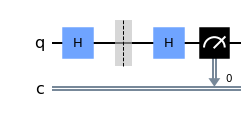

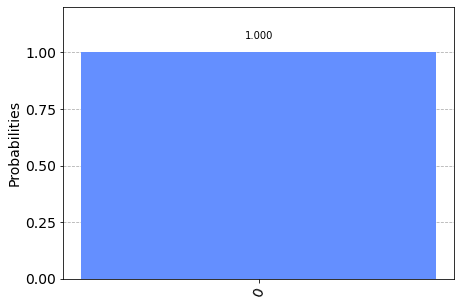

In [2]:
qc = QuantumCircuit(1,1) # Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()

# Bob measures in X basis
qc.h(0)
qc.measure(0,0)

display(qc.draw())

qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

**He measures 0**

Now Eve eavesdrops and measures in Z basis, the output would change to |0⟩ or |1⟩

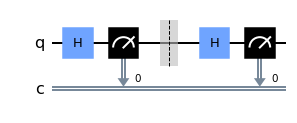

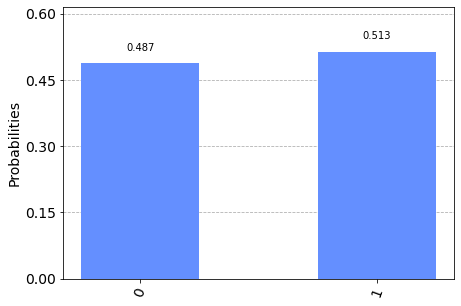

In [3]:
qc = QuantumCircuit(1,1) # Alice prepares qubit in state |+>
qc.h(0)# Alice now sends the qubit to Bob

# Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()

# Eve then passes this on to Bob who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

This shows there is no certainity that bob will measure 0

**If he measures 1, Bob an Alice would be aware of some trouble in their channel**

# Implementing the protocol

## Step1: Alice generates her qubits

In [4]:
np.random.seed(seed=3)

n = int(input('Enter value of n '))

alice_bits = randint(2, size=n)
print(alice_bits)

Enter value of n 100
[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


## Step2: Alice encodes these in Z and X bases

In [5]:
# to encode the string of qubits

def encode_message(bits, basis):
    
    message = []
    for i in range(n):
        qc = QuantumCircuit(1, 1)
        # prepare in z basis
        if basis[i] == 0:
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        # prepare in x basis
        else:
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        
        qc.barrier()
        message.append(qc)
        
    return message

In [6]:
np.random.seed(seed=3)

alice_bits = randint(2, size=n) ## Step 1

## Step 2
alice_basis = randint(2, size=n)
message = encode_message(alice_bits, alice_basis)

print(alice_basis)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


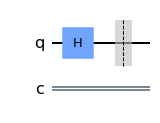

In [7]:
message[0].draw() # finding state of 1st qubit

First qubit is in the state |+⟩

Since Alice sent the message using Eve's channel, where Eve intercepts and measures it

In [8]:
# applies corresponding measurnment and simulates the result

def measure_message(message, basis):
    
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        # measuring in Z-basis
        if basis[q] == 0:
            message[q].measure(0,0)
        
        # measuring in X-basis
        if basis[q] == 1:
            message[q].h(0)
            message[q].measure(0,0)
        
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
        
    return measurements

In [9]:
np.random.seed(seed=3)

alice_bits = randint(2, size=n) ## Step 1

## Step 2
alice_basis = randint(2, size=n)
message = encode_message(alice_bits, alice_basis)

## Interception
eve_basis = randint(2, size=n)
intercepted_message = measure_message(message, eve_basis)

print(intercepted_message)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


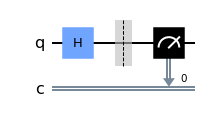

In [10]:
message[0].draw()

Eve's choice of basis was not the same as Alice's, this changes the qubit state from |+⟩ to a state in Z basis where there is a 50% probability of |0⟩ or |1⟩

## Step3: Eve passes message to Bob

**Bob measures in same basis as Alice**

In [11]:
np.random.seed(seed=3)

alice_bits = randint(2, size=n) ## Step 1

## Step 2
alice_basis = randint(2, size=n)
message = encode_message(alice_bits, alice_basis)

## Interception
eve_basis = randint(2, size=n)
intercepted_message = measure_message(message, eve_basis)

## Step 3
bob_basis = randint(2, size=n)
bob_results = measure_message(message, bob_basis)

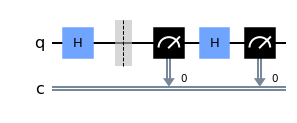

In [12]:
message[0].draw()

Due to interception Bob has a 50% chance of measuring 1 instead of always measuring 0

## Step4: Alice and Bob reveal their best basis and discard the others

In [13]:
# function to discard useless basis

def remove_garbage(a_basis, b_basis, bits):
    good_bits = []
    for q in range(n):
        if a_basis[q] == b_basis[q]:
            good_bits.append(bits[q]) # If both used the same basis, add to the list of 'good' bits
    
    return good_bits

In [14]:
np.random.seed(seed=3)

alice_bits = randint(2, size=n) ## Step 1

## Step 2
alice_basis = randint(2, size=n)
message = encode_message(alice_bits, alice_basis)

## Interception
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_basis)

## Step 3
bob_basis = randint(2, size=n)
bob_results = measure_message(message, bob_basis)

## Step 4
bob_key = remove_garbage(alice_basis, bob_basis, bob_results)
alice_key = remove_garbage(alice_basis, bob_basis, alice_bits)

In [15]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits)) # To make sure the bit we sample is always in the list range
        sample.append(bits.pop(i)) # pop(i) removes the element of the list at index 'i'
        
    return sample

In [16]:
np.random.seed(seed=3)

alice_bits = randint(2, size=n) ## Step 1

## Step 2
alice_basis = randint(2, size=n)
message = encode_message(alice_bits, alice_basis)

## Interception
eve_basis = randint(2, size=n)
intercepted_message = measure_message(message, eve_basis)

## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_basis)

## Step 4
bob_key = remove_garbage(alice_basis, bob_basis, bob_results)
alice_key = remove_garbage(alice_basis, bob_basis, alice_bits)

## Step 5
sample_size = int(input('Sample size: '))
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)

print("bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

Sample size: 15
bob_sample = [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [17]:
bob_sample==alice_sample

False

All the keys do not match because Eve intercepted and tried to chang the qubit states. The have to throw away all the results and try again.

# Proof of interception

In [18]:
#Step 1
alice_bits = randint(2, size=n)
alice_basis = randint(2, size=n)

message = encode_message(alice_bits, alice_basis) # Step 2

# Interception!
eve_basis = randint(2, size=n)
intercepted_message = measure_message(message, eve_basis)

# Step 3
bob_basis = randint(2, size=n)
bob_results = measure_message(message, bob_basis)

# Step 4
bob_key = remove_garbage(alice_basis, bob_basis, bob_results)
alice_key = remove_garbage(alice_basis, bob_basis, alice_bits)

# Step 5
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.
